# Определение возраста покупателей

## Исследовательский анализ данных

In [8]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
print("Размер выборки:", labels.shape)

Размер выборки: (7591, 2)


In [8]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Распределение возраста в выбрке

<AxesSubplot:>

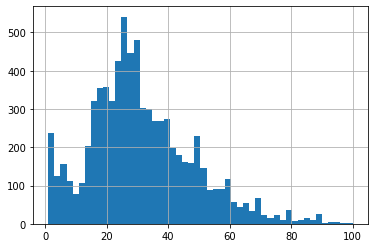

In [6]:
labels['real_age'].hist(bins=50)

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

<AxesSubplot:>

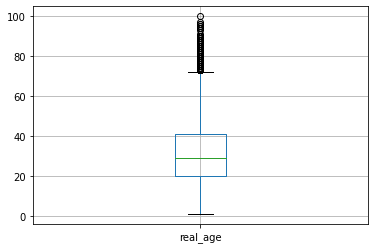

In [5]:
labels.boxplot('real_age')

15 фото из выборки

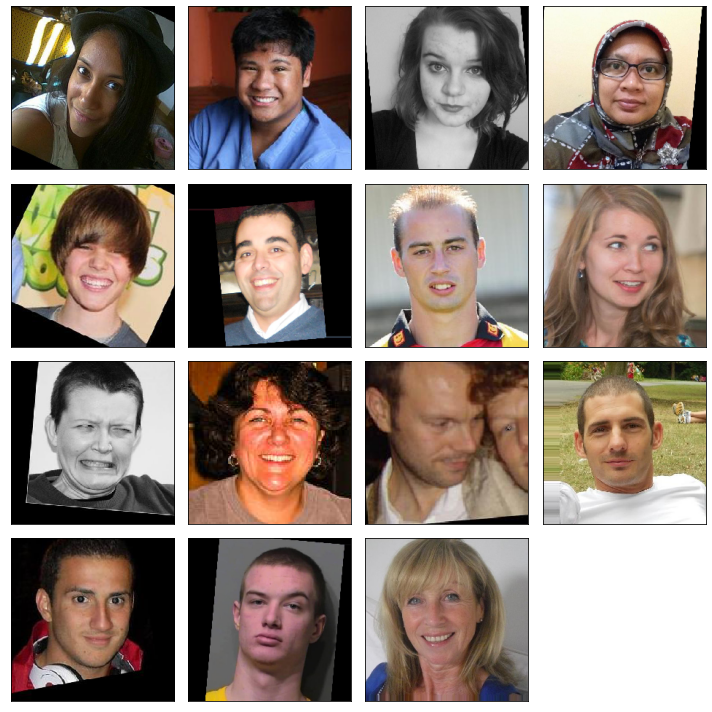

In [12]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

Выборка содержит 7591 фотографию людей в возрасте от 1 до 100 лет, без пропусков. Из графика видно, что возраст распределен неравномерно. 75% фото людей возраста до 41 года, что может привести к худшему предсказанию возраста людей старшего поколения. На boxplot видны выбросы значений более 70 лет.

Среди фотографий встречаются черно-белые, повернутые где-то на 15-20 градусов, изображения в полупрофиль, фотогарафии с разным разрешением. Учитывая выше перечисленные особенности набора, возможно, имеет смысл применить аугментацию к части фотографий: сделать черно-белыми, произвольный поворот от 0 до 20 градусов от вертикали, отображение по горизонтали, ухудшение контрастности. При помощи аугментации, вероятно, стоит увеличить количество фото людей старшего возраста.

## Обучение модели

Код модели для обучения на GPU

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345) 
    return train_gen_flow 

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw',
        seed=12345) 
    return test_gen_flow 

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 

    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae']) 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

Результат обучения:

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-08-05 08:53:41.323673: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-05 08:53:43.575070: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 67s - loss: 11.2763 - mae: 11.2771 - val_loss: 29.5551 - val_mae: 29.5726
Epoch 2/10
178/178 - 38s - loss: 6.8400 - mae: 6.8405 - val_loss: 23.0005 - val_mae: 22.9959
Epoch 3/10
178/178 - 37s - loss: 5.5954 - mae: 5.5958 - val_loss: 17.0571 - val_mae: 17.0003
Epoch 4/10
178/178 - 37s - loss: 4.7861 - mae: 4.7864 - val_loss: 8.1952 - val_mae: 8.1811
Epoch 5/10
178/178 - 38s - loss: 4.2818 - mae: 4.2820 - val_loss: 7.2375 - val_mae: 7.2537
Epoch 6/10
178/178 - 37s - loss: 3.9068 - mae: 3.9075 - val_loss: 5.9857 - val_mae: 5.9982
Epoch 7/10
178/178 - 37s - loss: 3.5551 - mae: 3.5553 - val_loss: 6.3876 - val_mae: 6.4207
Epoch 8/10
178/178 - 37s - loss: 3.3010 - mae: 3.3012 - val_loss: 6.2892 - val_mae: 6.3101
Epoch 9/10
178/178 - 37s - loss: 3.0410 - mae: 3.0406 - val_loss: 6.7423 - val_mae: 6.7348
Epoch 10/10
178/178 - 37s - loss: 2.7393 - mae: 2.7394 - val_loss: 5.9019 - val_mae: 5.9234
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 5.9019 - mae: 5.9234
Test MAE: 5.9234
```

## Анализ обученной модели

Для обучения была применена модель архитектуры ResNet50, где выходной слой заменен на 1 нейрон, возвращающий число-предсказание. По прошествии 10 эпох при использовании алгоритма Adam (learning rate = 0.0001) на тестовой выборке получена метрика MAE равная 5.9, что является отличным результатом. 

## Заключение

Достигнутой метрики MAE=6 вполне хватит чтобы предлагать товары, которые могут заинтересовать покупателей той или иной возрастной группы. Однако она не кажется достаточной для контроля за добросовестностью кассиров при продаже алкоголя. Со временем сеть супермаркетов может накопить достаточно фотографий покупателей (снятых с одного ракурса и хорошем освещении) для дообучения модели и достижения лучшей точности. Надо только мотивировать покупателей сообщать свой возраст :)